<a href="https://colab.research.google.com/github/vineet891/FODS-Assignment/blob/PartA/Assignment1/FODS_A1_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
from tqdm import notebook

**Loading Dataset**

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/FODSAssignment/FoDS-A1.csv')
df

,Strength,Temperature,Pressure
0,30.7,240,16
1,24.7,250,18
2,30.6,260,16
3,32.8,240,10
4,20.7,240,20
...,...,...,...
1645,32.5,270,20
1646,38.6,290,14
1647,39.7,290,12
1648,14.6,200,20


Data Preprocessing

In [4]:
#shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df

,Strength,Temperature,Pressure
0,43.8,290,12
1,31.2,270,16
2,34.7,300,18
3,31.7,280,18
4,40.2,290,12
...,...,...,...
1645,20.7,210,20
1646,25.2,260,20
1647,22.4,200,10
1648,22.7,220,14


In [5]:
df.describe()

,Strength,Temperature,Pressure
count,1650.000000,1650.000000,1650.000000
mean,30.000000,250.000000,15.000000
std,7.390248,31.632364,3.416686
min,12.400000,200.000000,10.000000
25%,24.400000,220.000000,12.000000
50%,30.200000,250.000000,15.000000
75%,35.700000,280.000000,18.000000
max,48.700000,300.000000,20.000000


In [6]:
# standardize the dataset
df = (df-np.mean(df,axis=0))/np.std(df,axis=0)
df

,Strength,Temperature,Pressure
0,1.867892,1.264911,-0.87831
1,0.162425,0.632456,0.29277
2,0.636166,1.581139,0.87831
3,0.230103,0.948683,0.87831
4,1.380616,1.264911,-0.87831
...,...,...,...
1645,-1.258797,-1.264911,1.46385
1646,-0.649701,0.316228,1.46385
1647,-1.028694,-1.581139,-1.46385
1648,-0.988088,-0.948683,-0.29277


In [7]:
# split the data set into 70:30 train:test 
split_index = int(0.7*len(df))

data = df.values
X = data[:,:-1]
y = data[:,-1]

train_X = X[:split_index]
train_y = y[:split_index]

test_X = X[split_index:]
test_y = y[split_index:]


array([[ 1.86789178,  1.26491106],
       [ 0.16242537,  0.63245553],
       [ 0.63616604,  1.58113883],
       ...,
       [ 1.05576492,  1.26491106],
       [ 0.09474813,  0.9486833 ],
       [ 0.23010261, -0.31622777]])

In [8]:
#transform the data to degree n
def transform(X,degree):
  X_trans = np.ones((len(X[:,1]), 1), dtype=int)
  for i in range(degree+1):
    for j in range(degree+1-i):
      if i!=0 or j!=0:
        t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
        X_trans = np.concatenate((X_trans, t.T), axis=1)
  return X_trans

**MODEL**

In [27]:
class Regression():

    def __init__(self, X_train, X_test, y_train, y_test):
        self.w = None
        self.X_train, self.X_test, self.y_train, self.y_test = X_train,X_test,y_train, y_test

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])  

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        return (y_pred - y)*x

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)[0]
        print("Testing Error is ", test_loss)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=True, printValues=True):

        self.w = np.random.randn(1, X.shape[1])     

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        count=0
        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)   
                    self.w -= learning_rate * (dw/X.shape[0])   

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)   
                self.w -= learning_rate * dw   

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]  
                if printValues and i%50==0:
                    print('Epoch:', i,'Loss:', loss[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        self.evaluate(self.X_test,self.y_test)


**0 Degree Polynomial**

In [49]:
# transform the dataset to degree 0
x_train_trans_0 = transform(train_X,0)
x_test_trans_0 = transform(test_X,0)

Training...


  0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.5021189146339171
Epoch: 50 Loss: 0.9950930052152606
Epoch: 100 Loss: 0.9784077888972602
Epoch: 150 Loss: 0.9779557310007672


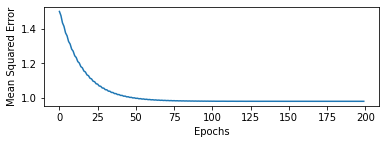

Testing
Testing Error is  1.0519845204836467


In [50]:
# Train and Test the 0-degree regression model with Gradient Descent
GD0 = Regression(x_train_trans_0, x_test_trans_0, train_y, test_y)
GD0.fit(x_train_trans_0, train_y,epochs = 200, learning='GD', learning_rate=0.01)

Training...


  0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 4.3776116370775116
Epoch: 50 Loss: 2.2709813989361365
Epoch: 100 Loss: 1.3502645308879544
Epoch: 150 Loss: 1.1507002769827306
Epoch: 200 Loss: 1.0093672405079206
Epoch: 250 Loss: 0.984348016744303
Epoch: 300 Loss: 0.982216274459865
Epoch: 350 Loss: 0.983682471224987
Epoch: 400 Loss: 0.9779636885695441
Epoch: 450 Loss: 0.9807910392721535
Epoch: 500 Loss: 0.9794939231812685
Epoch: 550 Loss: 0.9841378277619376
Epoch: 600 Loss: 0.9864295900169082
Epoch: 650 Loss: 0.9859501663069614
Epoch: 700 Loss: 0.9800908305090767
Epoch: 750 Loss: 0.9840838579484353
Epoch: 800 Loss: 0.9903941225613353
Epoch: 850 Loss: 0.9833668456826588
Epoch: 900 Loss: 0.984905335899361
Epoch: 950 Loss: 0.983057276995097


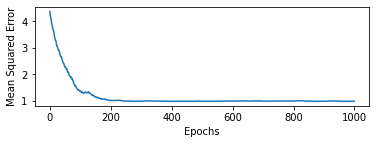

Testing
Testing Error is  1.053706772612511


In [51]:
# Train and Test the 0-degree regression model with Stochastic Gradient Descent
SGD0 = Regression(x_train_trans_0, x_test_trans_0, train_y, test_y)
SGD0.fit(x_train_trans_0, train_y,epochs = 1000, learning='SGD', learning_rate=0.01)

**1 Degree Polynomial**

In [37]:
x_train_trans_1 = transform(train_X,1)
x_test_trans_1 = transform(test_X,1)

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.252748137330445
Epoch: 50 Loss: 0.24270729448673964
Epoch: 100 Loss: 0.20014098936504052
Epoch: 150 Loss: 0.19851822626093277
Epoch: 200 Loss: 0.19852739017922655
Epoch: 250 Loss: 0.1985465734225003
Epoch: 300 Loss: 0.19855156541217886
Epoch: 350 Loss: 0.19855269103288486
Epoch: 400 Loss: 0.19855293796350737
Epoch: 450 Loss: 0.19855299181835812


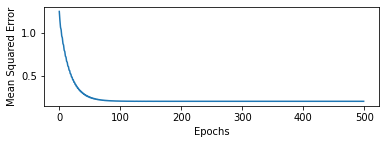

Testing
Testing Error is  0.20851111611268489


In [39]:
GD1 = Regression(x_train_trans_1, x_test_trans_1, train_y, test_y)
GD1.fit(x_train_trans_1, train_y,epochs = 500, learning='GD', learning_rate=0.01)

Training...


  0%|          | 0/1500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 6.68044685254399
Epoch: 50 Loss: 3.1928243718200093
Epoch: 100 Loss: 1.906651452273841
Epoch: 150 Loss: 1.3250209795786323
Epoch: 200 Loss: 1.067310434645728
Epoch: 250 Loss: 0.9671162847866018
Epoch: 300 Loss: 0.8719829291550042
Epoch: 350 Loss: 0.7337824828139363
Epoch: 400 Loss: 0.629897745022932
Epoch: 450 Loss: 0.57036209656886
Epoch: 500 Loss: 0.5256355414905443
Epoch: 550 Loss: 0.47631793778154474
Epoch: 600 Loss: 0.4379089358698669
Epoch: 650 Loss: 0.42056835670835924
Epoch: 700 Loss: 0.37027991427594587
Epoch: 750 Loss: 0.3564577720263416
Epoch: 800 Loss: 0.333194272460368
Epoch: 850 Loss: 0.32509318246073454
Epoch: 900 Loss: 0.29751696110350534
Epoch: 950 Loss: 0.28302196168677407
Epoch: 1000 Loss: 0.26965718437793135
Epoch: 1050 Loss: 0.25943371065420945
Epoch: 1100 Loss: 0.25097707445606354
Epoch: 1150 Loss: 0.24448759284372784
Epoch: 1200 Loss: 0.24063595346816954
Epoch: 1250 Loss: 0.23617648542753078
Epoch: 1300 Loss: 0.22823692432163872
Epoch: 1350 Loss: 0

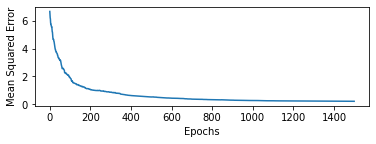

Testing
Testing Error is  0.23038992092019328


In [47]:
SGD1 = Regression(x_train_trans_1, x_test_trans_1, train_y, test_y)
SGD1.fit(x_train_trans_1, train_y,epochs = 1500, learning='SGD', learning_rate=0.01)

**2 Degree Polynomial**

In [31]:
x_train_trans_2 = transform(train_X,2)
x_test_trans_2 = transform(test_X,2)

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 11.444081659990067
Epoch: 50 Loss: 0.20478488774322232
Epoch: 100 Loss: 0.19818331039584428
Epoch: 150 Loss: 0.19598545914472992
Epoch: 200 Loss: 0.19525258794522993
Epoch: 250 Loss: 0.19503498255031654
Epoch: 300 Loss: 0.19498890532316382
Epoch: 350 Loss: 0.19499358317259682
Epoch: 400 Loss: 0.19500887152451302
Epoch: 450 Loss: 0.1950229333702624


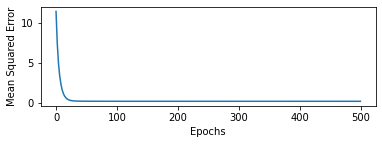

Testing
Testing Error is  0.20628454184055797


In [68]:
GD2 = Regression(x_train_trans_2, x_test_trans_2, train_y, test_y)
GD2.fit(x_train_trans_2, train_y,epochs = 500, learning='GD', learning_rate=0.001)

Training...


  0%|          | 0/1500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 8.303424510412103
Epoch: 50 Loss: 0.6815724996482869
Epoch: 100 Loss: 0.6082629472305087
Epoch: 150 Loss: 0.5489232192254534
Epoch: 200 Loss: 0.48875848670051397
Epoch: 250 Loss: 0.48650843138294264
Epoch: 300 Loss: 0.413218138547025
Epoch: 350 Loss: 0.3862917491777189
Epoch: 400 Loss: 0.3536133020742487
Epoch: 450 Loss: 0.32439076630551644
Epoch: 500 Loss: 0.31700648593924985
Epoch: 550 Loss: 0.3081810652647152
Epoch: 600 Loss: 0.2760652451553324
Epoch: 650 Loss: 0.298497574326398
Epoch: 700 Loss: 0.27140700767429937
Epoch: 750 Loss: 0.27796453554334893
Epoch: 800 Loss: 0.23809921809180945
Epoch: 850 Loss: 0.23296243092199306
Epoch: 900 Loss: 0.2419760309117905
Epoch: 950 Loss: 0.2260062335408222
Epoch: 1000 Loss: 0.23649410404083418
Epoch: 1050 Loss: 0.2303013570203943
Epoch: 1100 Loss: 0.2275252041379468
Epoch: 1150 Loss: 0.21882228098391834
Epoch: 1200 Loss: 0.20893788144252196
Epoch: 1250 Loss: 0.22792188645373787
Epoch: 1300 Loss: 0.2137306098542141
Epoch: 1350 Los

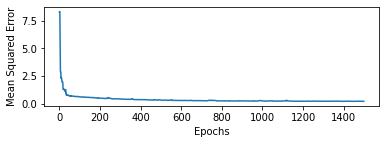

Testing
Testing Error is  0.22000291226802682


In [44]:
SGD2 = Regression(x_train_trans_2, x_test_trans_2, train_y, test_y)
SGD2.fit(x_train_trans_2, train_y,epochs = 1500, learning='SGD', learning_rate=0.01)

**3 Degree Polynomial**

In [60]:
x_train_trans_3 = transform(train_X,3)
x_test_trans_3 = transform(test_X,3)


Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.5744551029760947
Epoch: 50 Loss: 0.23987406904963837
Epoch: 100 Loss: 0.20346105838812129
Epoch: 150 Loss: 0.19186619926558277
Epoch: 200 Loss: 0.1878145931754138
Epoch: 250 Loss: 0.1863827296574105
Epoch: 300 Loss: 0.18586071997021714
Epoch: 350 Loss: 0.18564523754628962
Epoch: 400 Loss: 0.18552787914819982
Epoch: 450 Loss: 0.18544012196574017


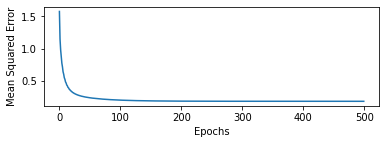

Testing
Testing Error is  0.19576571356460148


In [65]:
GD3 = Regression(x_train_trans_3, x_test_trans_3, train_y, test_y)
GD3.fit(x_train_trans_3, train_y,epochs = 500, learning='GD', learning_rate=0.001)

Training...


  0%|          | 0/2500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 39.18078611168509
Epoch: 50 Loss: 3.5134299457076756
Epoch: 100 Loss: 2.9345039674366147
Epoch: 150 Loss: 1.9985660029276238
Epoch: 200 Loss: 2.0727841373729907
Epoch: 250 Loss: 1.827187851398565
Epoch: 300 Loss: 1.3053365880005348
Epoch: 350 Loss: 1.5912320862391984
Epoch: 400 Loss: 2.2338043061302253
Epoch: 450 Loss: 0.9413574528074756
Epoch: 500 Loss: 0.8714261218084187
Epoch: 550 Loss: 0.8447794416531648
Epoch: 600 Loss: 1.004706433889329
Epoch: 650 Loss: 1.1342411685435447
Epoch: 700 Loss: 0.7121815670486397
Epoch: 750 Loss: 0.7556227484420905
Epoch: 800 Loss: 0.8107713149789968
Epoch: 850 Loss: 0.856340367157958
Epoch: 900 Loss: 0.6138774101694804
Epoch: 950 Loss: 0.6149585968442999
Epoch: 1000 Loss: 0.5497567417516481
Epoch: 1050 Loss: 0.7590196183115603
Epoch: 1100 Loss: 0.5082444372483106
Epoch: 1150 Loss: 0.562697663750909
Epoch: 1200 Loss: 0.47346011340094973
Epoch: 1250 Loss: 0.4995672819988981
Epoch: 1300 Loss: 0.4476962083237717
Epoch: 1350 Loss: 0.43229930

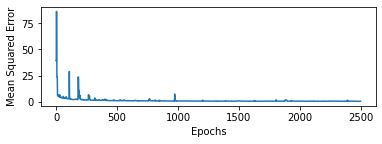

Testing
Testing Error is  0.3314218770399761


In [70]:
SGD3 = Regression(x_train_trans_3, x_test_trans_3, train_y, test_y)
SGD3.fit(x_train_trans_3, train_y,epochs = 2500, learning='SGD', learning_rate=0.01)